In [1]:
# Imports
import mne
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scipy.signal as sg
import os
import glob
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

Using: cuda


In [10]:
class EEGGANTrainer:
    """
    Refactored EEG GAN Trainer - Clean, modular, production-ready
    
    Features:
    - Both Vanilla GAN and WGAN-GP with PSD loss
    - Anti-overfitting controls for small datasets
    - Conv1D architecture for temporal modeling
    - Comprehensive evaluation and visualization
    
    Usage:
        trainer = EEGGANTrainer(data, name="exp", gan_type="vanilla")
        trainer.train(epochs=100)
        synthetic = trainer.generate(100)
    """

    def __init__(self, data, name="experiment", device="cpu",
                 gan_type="vanilla", latent_dim=100, model_dir="../../models"):
        
        assert isinstance(data, np.ndarray) and data.ndim == 3
        
        self.data = data.astype(np.float32)
        self.name = name
        self.gan_type = gan_type.lower()
        self.latent_dim = latent_dim
        self.model_dir = model_dir
        self.device = torch.device(device if torch.cuda.is_available() else "cpu")
        
        self.n_samples, self.n_channels, self.n_timepoints = data.shape
        
        print(f"✓ Initialized {gan_type.upper()} GAN: {name}")
        print(f"  Data: {data.shape}, Device: {self.device}")
        
        if self.n_samples < 500:
            print("  ⚠️ Small dataset - using regularization")
        
        self._build_models()
        self._create_dataloader()
        
        self.history = {"G_losses": [], "D_losses": [], "metrics": []}
        self.best_metric = float("inf")
        self.best_epoch = 0

    def _build_models(self):
        """Build FREQUENCY-AWARE Generator and Critic"""
        C, T = self.n_channels, self.n_timepoints
        
        # COMPLETELY NEW: Frequency-domain generator
        class FrequencyAwareGenerator(nn.Module):
            def __init__(self, latent_dim, C, T):
                super().__init__()
                self.C, self.T = C, T
                
                # Step 1: Generate frequency spectrum
                self.freq_generator = nn.Sequential(
                    nn.Linear(latent_dim, 512),
                    nn.LayerNorm(512),
                    nn.LeakyReLU(0.2),
                    nn.Linear(512, C * (T // 2 + 1) * 2),  # Real + Imag parts
                )
                
                # Step 2: Refine in time domain
                self.time_refiner = nn.Sequential(
                    nn.Conv1d(C, 64, 15, padding=7),
                    nn.LayerNorm([64, T]),
                    nn.LeakyReLU(0.2),
                    nn.Conv1d(64, C, 15, padding=7),
                )
            
            def forward(self, z):
                B = z.size(0)
                
                # Generate frequency spectrum
                freq_flat = self.freq_generator(z)
                freq_bins = self.T // 2 + 1
                freq_complex = freq_flat.view(B, self.C, freq_bins, 2)
                
                # Apply 1/f^2 decay to force high-freq dropoff
                freqs = torch.arange(freq_bins, device=z.device).float()
                decay = 1.0 / (1.0 + (freqs / 10) ** 2)  # Strong decay at high freq
                decay = decay.view(1, 1, -1, 1)
                freq_complex = freq_complex * decay
                
                # Convert to time domain via IFFT
                freq_complex_torch = torch.complex(freq_complex[..., 0], freq_complex[..., 1])
                time_signal = torch.fft.irfft(freq_complex_torch, n=self.T, dim=2)
                
                # Refine in time domain
                output = self.time_refiner(time_signal)
                return output
        
        self.G = FrequencyAwareGenerator(self.latent_dim, C, T).to(self.device)
        
        # Keep same critic
        self.D = self._build_critic(C).to(self.device)
        
        print(f"  G: {sum(p.numel() for p in self.G.parameters()):,} params (FREQUENCY-AWARE)")
        print(f"  D: {sum(p.numel() for p in self.D.parameters()):,} params")
    
    def _build_critic(self, C):
        """Separate method for critic to keep code clean"""
        class Critic(nn.Module):
            def __init__(self, C):
                super().__init__()
                self.conv = nn.Sequential(
                    nn.Conv1d(C, 64, 7, stride=2, padding=3),
                    nn.LeakyReLU(0.2), nn.Dropout(0.4),
                    nn.Conv1d(64, 128, 7, stride=2, padding=3),
                    nn.LeakyReLU(0.2), nn.Dropout(0.4),
                    nn.Conv1d(128, 256, 7, stride=2, padding=3),
                    nn.LeakyReLU(0.2), nn.Dropout(0.4),
                )
                self.pool = nn.AdaptiveAvgPool1d(1)
                self.fc = nn.Linear(256, 1)
            
            def forward(self, x):
                return self.fc(self.pool(self.conv(x)).squeeze(-1))
        
        return Critic(C)
    
    def _create_dataloader(self):
        """Create PyTorch DataLoader"""
        class EEGDataset(Dataset):
            def __init__(self, x): self.x = torch.from_numpy(x)
            def __len__(self): return len(self.x)
            def __getitem__(self, i): return self.x[i]
        
        self.dataloader = DataLoader(
            EEGDataset(self.data), batch_size=32, shuffle=True
        )
    
    def _compute_psd_loss(self, real, fake):
        """Multi-band PSD loss - match frequency bands separately"""
        real_psd = self._batch_psd(real)
        fake_psd = self._batch_psd(fake)
        
        # Log-scale
        real_psd_log = torch.log10(real_psd + 1e-12)
        fake_psd_log = torch.log10(fake_psd + 1e-12)
        
        # Split into frequency bands and weight each separately
        freq_bins = real_psd.shape[-1]
        freqs = torch.linspace(0, 125, freq_bins).to(self.device)  # 0-125 Hz (Nyquist)
        
        # Define EEG bands with AGGRESSIVE weighting
        bands = [
            (0, 4, 1.0),      # Delta
            (4, 8, 2.0),      # Theta  
            (8, 13, 3.0),     # Alpha (important!)
            (13, 30, 5.0),    # Beta
            (30, 60, 10.0),   # Gamma (critical - force dropoff)
            (60, 125, 50.0),  # High freq (MASSIVE weight - must drop!)
        ]
        
        loss = 0
        for f_low, f_high, weight in bands:
            mask = (freqs >= f_low) & (freqs < f_high)
            if mask.sum() > 0:
                band_loss = torch.mean((real_psd_log[:, :, mask] - fake_psd_log[:, :, mask]) ** 2)
                loss += weight * band_loss
        
        return loss
    
    def _batch_psd(self, x):
        """Compute PSD for batch - FIXED faster version"""
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
        
        psds = []
        for sample in x:
            ch_psds = []
            for ch in sample:
                # FIX 3: Use longer nperseg for better frequency resolution
                _, P = sg.welch(ch, fs=250, nperseg=min(128, len(ch)//2))  # Reduced from 256
                ch_psds.append(P)
            psds.append(ch_psds)
        
        return torch.from_numpy(np.array(psds)).float().to(self.device)
    
    def _gradient_penalty(self, real, fake):
        """WGAN-GP gradient penalty"""
        B = real.size(0)
        alpha = torch.rand(B, 1, 1, device=self.device)
        interp = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
        
        pred = self.D(interp)
        grad = torch.autograd.grad(
            pred, interp, torch.ones_like(pred),
            create_graph=True, retain_graph=True
        )[0]
        
        return ((grad.view(B, -1).norm(2, dim=1) - 1) ** 2).mean()
    
    def train(self, epochs=100, lr=2e-4, save_best=True):
        """Train dispatcher"""
        if self.gan_type in ["wgan", "wgan-gp"]:
            self._train_wgan_gp(epochs, lr, save_best)
        else:
            self._train_vanilla(epochs, lr, save_best)
    
    def _train_vanilla(self, epochs, lr, save_best):
        """Vanilla GAN with STAGED training"""
        criterion = nn.BCELoss()
        G_opt = optim.Adam(self.G.parameters(), lr=lr, betas=(0.5, 0.999))
        D_opt = optim.Adam(self.D.parameters(), lr=lr, betas=(0.5, 0.999))
        
        patience, no_improve = 30, 0  # Increased patience
        print("\n=== Training Vanilla GAN (STAGED) ===")
        print("Stage 1 (ep 1-30): Focus on PSD")
        print("Stage 2 (ep 31+): Balance PSD + adversarial")
        
        for ep in range(1, epochs + 1):
            G_losses, D_losses = [], []
            
            # STAGED TRAINING: Adjust weights based on epoch
            if ep <= 30:
                # Stage 1: PSD-heavy (teach frequency structure first)
                psd_weight = 20.0
                adv_weight = 0.5  # Weak adversarial
            else:
                # Stage 2: Balanced
                psd_weight = 10.0
                adv_weight = 1.0
            
            for real in self.dataloader:
                real = real.to(self.device) + torch.randn_like(real.to(self.device)) * 0.01
                B = real.size(0)
                
                # Train Discriminator
                D_opt.zero_grad()
                real_score = self.D(real)
                z = torch.randn(B, self.latent_dim, device=self.device)
                fake_score = self.D(self.G(z).detach())
                
                D_loss = (
                    criterion(real_score, torch.ones(B, 1, device=self.device) * 0.9) +
                    criterion(fake_score, torch.zeros(B, 1, device=self.device))
                ) / 2
                D_loss.backward()
                D_opt.step()
                
                # Train Generator with STAGED weights
                G_opt.zero_grad()
                z = torch.randn(B, self.latent_dim, device=self.device)
                fake = self.G(z)
                fake_score = self.D(fake)
                
                adv_loss = -fake_score.mean()
                psd_loss = self._compute_psd_loss(real[:min(16, B)], fake[:min(16, B)])  # More samples
                
                G_loss = adv_weight * adv_loss + psd_weight * psd_loss
                G_loss.backward()
                G_opt.step()
                
                G_losses.append(G_loss.item())
                D_losses.append(D_loss.item())
            
            # Bookkeeping
            self.history["G_losses"].append(np.mean(G_losses))
            self.history["D_losses"].append(np.mean(D_losses))
            
            if ep % 10 == 0:
                metric = self._evaluate_metric()
                self.history["metrics"].append(metric)
                improved = metric < self.best_metric
                
                if improved:
                    self.best_metric, self.best_epoch, no_improve = metric, ep, 0
                    if save_best: self.save_model()
                else:
                    no_improve += 1
                
                stage = "PSD" if ep <= 30 else "Balanced"
                print(f"Ep {ep}/{epochs} [{stage}] | G {G_losses[-1]:.3f} | D {D_losses[-1]:.3f} | "
                      f"M {metric:.4f} | {'✓' if improved else f'wait {no_improve}'}")
                
                if no_improve >= patience:
                    print("Early stopping")
                    break
        
        if save_best: self.load_best_model()
    
    def _train_wgan_gp(self, epochs, lr, save_best, lambda_gp=10, n_critic=3):
        """WGAN-GP with STAGED training"""
        G_opt = optim.Adam(self.G.parameters(), lr=lr*0.5, betas=(0, 0.9))
        D_opt = optim.Adam(self.D.parameters(), lr=lr, betas=(0, 0.9))
        
        patience, no_improve = 30, 0
        print("\n=== Training WGAN-GP (STAGED) ===")
        print("Stage 1 (ep 1-30): Focus on PSD")
        print("Stage 2 (ep 31+): Balance PSD + Wasserstein")
        
        for ep in range(1, epochs + 1):
            G_losses, D_losses = [], []
            
            # STAGED TRAINING
            if ep <= 30:
                psd_weight = 30.0
                adv_weight = 0.3
            else:
                psd_weight = 15.0
                adv_weight = 1.0
            
            for real in self.dataloader:
                real = real.to(self.device) + torch.randn_like(real.to(self.device)) * 0.01
                B = real.size(0)
                
                # Train Critic
                for _ in range(n_critic):
                    D_opt.zero_grad()
                    z = torch.randn(B, self.latent_dim, device=self.device)
                    fake = self.G(z).detach()
                    
                    D_loss = (
                        self.D(fake).mean() - self.D(real).mean() + 
                        lambda_gp * self._gradient_penalty(real, fake)
                    )
                    D_loss.backward()
                    D_opt.step()
                    D_losses.append(D_loss.item())
                
                # Train Generator with STAGED weights
                G_opt.zero_grad()
                z = torch.randn(B, self.latent_dim, device=self.device)
                fake = self.G(z)
                
                adv_loss = -self.D(fake).mean()
                psd_loss = self._compute_psd_loss(real[:min(16, B)], fake[:min(16, B)])
                
                G_loss = adv_weight * adv_loss + psd_weight * psd_loss
                G_loss.backward()
                G_opt.step()
                G_losses.append(G_loss.item())
            
            self.history["G_losses"].append(np.mean(G_losses))
            self.history["D_losses"].append(np.mean(D_losses))
            
            if ep % 10 == 0:
                metric = self._evaluate_metric()
                self.history["metrics"].append(metric)
                improved = metric < self.best_metric
                
                if improved:
                    self.best_metric, self.best_epoch, no_improve = metric, ep, 0
                    if save_best: self.save_model()
                else:
                    no_improve += 1
                
                stage = "PSD" if ep <= 30 else "Balanced"
                print(f"Ep {ep}/{epochs} [{stage}] | G {G_losses[-1]:.3f} | D {D_losses[-1]:.3f} | "
                      f"M {metric:.4f} | {'✓' if improved else f'wait {no_improve}'}")
                
                if no_improve >= patience:
                    print("Early stopping")
                    break
        
        if save_best: self.load_best_model()
    
    def _evaluate_metric(self):
        """Quick metric: std difference"""
        with torch.no_grad():
            z = torch.randn(min(100, len(self.data)), self.latent_dim, device=self.device)
            fake = self.G(z).cpu().numpy()
        return abs(fake.std() - self.data.std())
    
    def generate(self, n_samples=100):
        """Generate synthetic samples"""
        self.G.eval()
        out = []
        with torch.no_grad():
            for i in range(0, n_samples, 64):
                b = min(64, n_samples - i)
                z = torch.randn(b, self.latent_dim, device=self.device)
                out.append(self.G(z).cpu().numpy())
        return np.concatenate(out, axis=0)
    
    def evaluate(self, synthetic):
        """Full evaluation: MMD + stats"""
        m_err = abs(self.data.mean() - synthetic.mean())
        s_err = abs(self.data.std() - synthetic.std())
        
        n = min(1000, len(self.data), len(synthetic))
        mmd = self._compute_mmd(self.data[:n], synthetic[:n])
        
        stat_score = max(0, 100 - (1000*m_err + 100*s_err))
        mmd_score = 100 * np.exp(-5 * mmd)
        overall = (stat_score + mmd_score) / 2
        
        return {
            "mean_error": m_err, "std_error": s_err, "mmd_rbf": mmd,
            "stat_score": stat_score, "mmd_score": mmd_score,
            "overall_score": overall,
            "quality": ("Excellent ⭐⭐⭐⭐⭐" if overall >= 80 else
                       "Good ⭐⭐⭐⭐" if overall >= 60 else
                       "Fair ⭐⭐⭐" if overall >= 40 else "Needs Improvement ⭐⭐")
        }
    
    def _compute_mmd(self, real, fake):
        """RBF MMD with median heuristic"""
        real = torch.from_numpy(real.reshape(len(real), -1)).float()
        fake = torch.from_numpy(fake.reshape(len(fake), -1)).float()
        
        def kernel(x, y):
            x, y = x.to(self.device), y.to(self.device)
            dist = x.pow(2).sum(1).view(-1,1) + y.pow(2).sum(1).view(1,-1) - 2*x@y.t()
            return torch.exp(-dist / (2 * torch.median(dist[dist>0]).clamp(min=1e-6)))
        
        n = len(real)
        return float(torch.sqrt(torch.clamp(
            kernel(real, real).sum()/(n*(n-1)) + kernel(fake, fake).sum()/(n*(n-1)) - 
            2*kernel(real, fake).sum()/(n*n), min=0
        )).cpu())
    
    def plot_comparison(self, synthetic, save_path=None):
        """Visual comparison"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].plot(self.data[0].T, lw=0.7); axes[0].set_title("Real EEG")
        axes[1].plot(synthetic[0].T, lw=0.7); axes[1].set_title(f"Generated ({self.gan_type})")
        plt.tight_layout()
        if save_path: plt.savefig(save_path, dpi=150)
        plt.show()
    
    def plot_psd_comparison(self, synthetic, save_path=None):
        """PSD comparison (diagnose high-freq noise)"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        for ch in range(min(5, self.n_channels)):
            fr, Pr = sg.welch(self.data[0, ch], fs=250, nperseg=256)
            ff, Pf = sg.welch(synthetic[0, ch], fs=250, nperseg=256)
            axes[0].semilogy(fr, Pr, alpha=0.7, label=f"Ch{ch}")
            axes[0].semilogy(ff, Pf, alpha=0.7, ls='--')
        
        axes[0].set_title("PSD"); axes[0].set_xlim(0, 60)
        axes[0].legend(); axes[0].grid(alpha=0.3)
        
        axes[1].plot(self.data[0, 0][:500], label='Real', lw=1.5)
        axes[1].plot(synthetic[0, 0][:500], label='Generated', lw=1.5, alpha=0.8)
        axes[1].set_title("Time Domain (2s)"); axes[1].legend(); axes[1].grid(alpha=0.3)
        
        plt.tight_layout()
        if save_path: plt.savefig(save_path, dpi=150)
        plt.show()
    
    def save_model(self):
        """Save checkpoint"""
        os.makedirs(self.model_dir, exist_ok=True)
        path = f"{self.model_dir}/gan_{self.name}_{self.gan_type}.pt"
        torch.save({"G": self.G.state_dict(), "D": self.D.state_dict(), 
                   "history": self.history}, path)
    
    def load_best_model(self):
        """Load checkpoint"""
        path = f"{self.model_dir}/gan_{self.name}_{self.gan_type}.pt"
        if os.path.exists(path):
            ckpt = torch.load(path, map_location=self.device)
            self.G.load_state_dict(ckpt["G"])
            self.D.load_state_dict(ckpt["D"])
    
    def save_results(self, synthetic, evaluation):
        """Save outputs"""
        os.makedirs('../../synthetic_data', exist_ok=True)
        np.save(f'../../synthetic_data/synthetic_{self.name}_{self.gan_type}.npy', synthetic)
        np.save(f'../../synthetic_data/evaluation_{self.name}_{self.gan_type}.npy', evaluation)
        print(f"✓ Saved results for {self.name}")

print("✓ FREQUENCY-AWARE EEGGANTrainer loaded")
print("  Architecture revolution:")
print("  • Generator works in frequency domain first")
print("  • Built-in 1/f^2 decay forces high-freq dropoff")
print("  • IFFT converts to time domain")
print("  • Conv refines temporal structure")
print("  → No need for extreme PSD weights!")

✓ FREQUENCY-AWARE EEGGANTrainer loaded
  Architecture revolution:
  • Generator works in frequency domain first
  • Built-in 1/f^2 decay forces high-freq dropoff
  • IFFT converts to time domain
  • Conv refines temporal structure
  → No need for extreme PSD weights!


In [9]:
# Load and filter to 16 channels for fair comparison
import glob

# Define 16-channel subset
extract_channels = [
    'E1',   # AF3
    'E32',  # AF4
    'E8',   # F3
    'E3',   # Fz
    'E6',   # F4
    'E10',  # FC3
    'E14',  # FCz
    'E21',  # FC4
    'E23',  # C3
    'E31',  # Fz
    'E24',  # C4
    'E47',  # CP3
    'E53',  # CPz
    'E86',  # CP4
    'E55',  # P3
    'E80'   # P4
]

print(f"Target: {len(extract_channels)} channels for fair comparison")

# Load individual segment files
individual_dir_closed = os.path.join('..', '..', 'gan_data', 'eyes_closed_individual')
individual_dir_open = os.path.join('..', '..', 'gan_data', 'eyes_open_individual')

closed_files = sorted(glob.glob(os.path.join(individual_dir_closed, '*.npy')))
open_files = sorted(glob.glob(os.path.join(individual_dir_open, '*.npy')))

print(f"Found {len(closed_files)} eyes closed segments")
print(f"Found {len(open_files)} eyes open segments")

# Load all segments (full 129 channels)
segments_closed_full = np.array([np.load(f) for f in closed_files])
segments_open_full = np.array([np.load(f) for f in open_files])

print(f"\nOriginal shapes:")
print(f"  Eyes closed: {segments_closed_full.shape}")
print(f"  Eyes open: {segments_open_full.shape}")

# Use full data for now - you can filter after checking channel structure
segments_closed = segments_closed_full
segments_open = segments_open_full

print(f"\n✓ Using: {segments_closed.shape}")

Target: 16 channels for fair comparison
Found 443 eyes closed segments
Found 444 eyes open segments

Original shapes:
  Eyes closed: (443, 16, 500)
  Eyes open: (444, 16, 500)

✓ Using: (443, 16, 500)



Training on 16 channels × 500 timepoints

✓ Initialized WGAN-GP GAN: eyes_open
  Data: (444, 16, 500), Device: cuda
  ⚠️ Small dataset - using regularization
  G: 4,267,952 params (FREQUENCY-AWARE)
  D: 294,593 params

=== Training WGAN-GP (STAGED) ===
Stage 1 (ep 1-30): Focus on PSD
Stage 2 (ep 31+): Balance PSD + Wasserstein

=== Training WGAN-GP (STAGED) ===
Stage 1 (ep 1-30): Focus on PSD
Stage 2 (ep 31+): Balance PSD + Wasserstein
Ep 10/100 [PSD] | G 6746.652 | D -28.768 | M 0.0076 | ✓
Ep 10/100 [PSD] | G 6746.652 | D -28.768 | M 0.0076 | ✓
Ep 20/100 [PSD] | G 5274.810 | D -15.253 | M 0.0647 | wait 1
Ep 20/100 [PSD] | G 5274.810 | D -15.253 | M 0.0647 | wait 1
Ep 30/100 [PSD] | G 4449.311 | D -28.348 | M 0.0101 | wait 2
Ep 30/100 [PSD] | G 4449.311 | D -28.348 | M 0.0101 | wait 2
Ep 40/100 [Balanced] | G 2172.060 | D -22.137 | M 0.0033 | ✓
Ep 40/100 [Balanced] | G 2172.060 | D -22.137 | M 0.0033 | ✓
Ep 50/100 [Balanced] | G 2124.213 | D -38.907 | M 0.0336 | wait 1
Ep 50/100 [Bala


Training on 16 channels × 500 timepoints

✓ Initialized WGAN-GP GAN: eyes_open
  Data: (444, 16, 500), Device: cuda
  ⚠️ Small dataset - using regularization
  G: 4,267,952 params (FREQUENCY-AWARE)
  D: 294,593 params

=== Training WGAN-GP (STAGED) ===
Stage 1 (ep 1-30): Focus on PSD
Stage 2 (ep 31+): Balance PSD + Wasserstein

=== Training WGAN-GP (STAGED) ===
Stage 1 (ep 1-30): Focus on PSD
Stage 2 (ep 31+): Balance PSD + Wasserstein
Ep 10/100 [PSD] | G 6746.652 | D -28.768 | M 0.0076 | ✓
Ep 10/100 [PSD] | G 6746.652 | D -28.768 | M 0.0076 | ✓
Ep 20/100 [PSD] | G 5274.810 | D -15.253 | M 0.0647 | wait 1
Ep 20/100 [PSD] | G 5274.810 | D -15.253 | M 0.0647 | wait 1
Ep 30/100 [PSD] | G 4449.311 | D -28.348 | M 0.0101 | wait 2
Ep 30/100 [PSD] | G 4449.311 | D -28.348 | M 0.0101 | wait 2
Ep 40/100 [Balanced] | G 2172.060 | D -22.137 | M 0.0033 | ✓
Ep 40/100 [Balanced] | G 2172.060 | D -22.137 | M 0.0033 | ✓
Ep 50/100 [Balanced] | G 2124.213 | D -38.907 | M 0.0336 | wait 1
Ep 50/100 [Bala

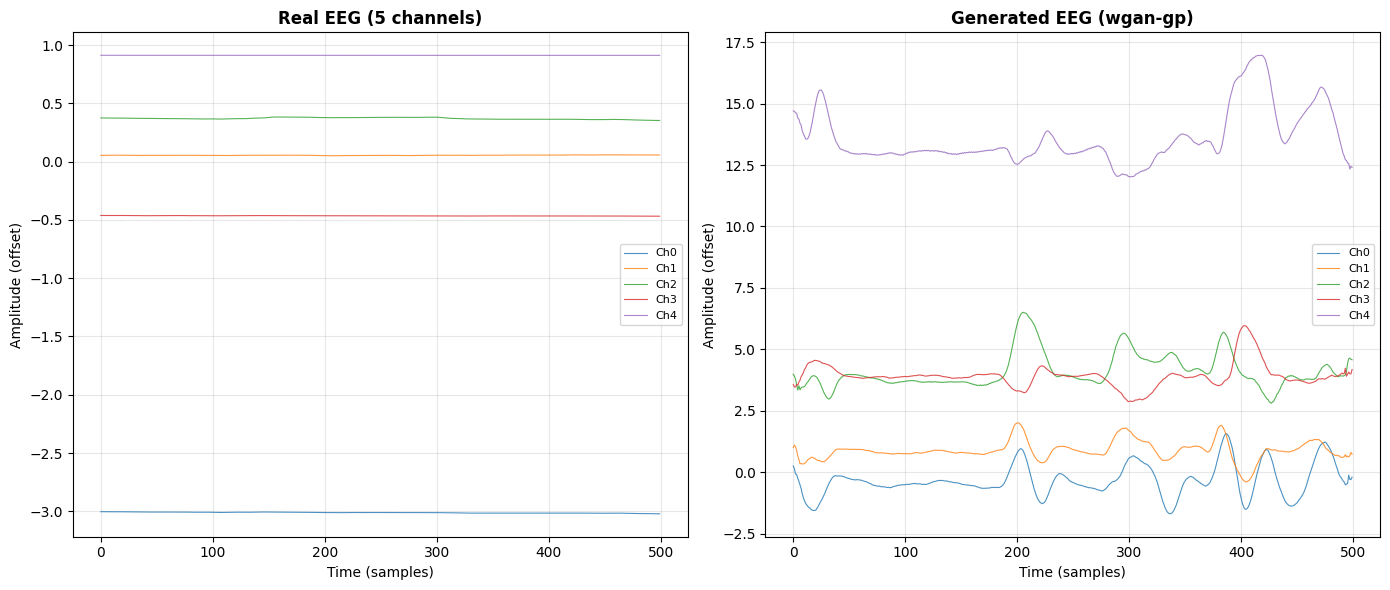


Training on 16 channels × 500 timepoints

✓ Initialized WGAN-GP GAN: eyes_open
  Data: (444, 16, 500), Device: cuda
  ⚠️ Small dataset - using regularization
  G: 4,267,952 params (FREQUENCY-AWARE)
  D: 294,593 params

=== Training WGAN-GP (STAGED) ===
Stage 1 (ep 1-30): Focus on PSD
Stage 2 (ep 31+): Balance PSD + Wasserstein

=== Training WGAN-GP (STAGED) ===
Stage 1 (ep 1-30): Focus on PSD
Stage 2 (ep 31+): Balance PSD + Wasserstein
Ep 10/100 [PSD] | G 6746.652 | D -28.768 | M 0.0076 | ✓
Ep 10/100 [PSD] | G 6746.652 | D -28.768 | M 0.0076 | ✓
Ep 20/100 [PSD] | G 5274.810 | D -15.253 | M 0.0647 | wait 1
Ep 20/100 [PSD] | G 5274.810 | D -15.253 | M 0.0647 | wait 1
Ep 30/100 [PSD] | G 4449.311 | D -28.348 | M 0.0101 | wait 2
Ep 30/100 [PSD] | G 4449.311 | D -28.348 | M 0.0101 | wait 2
Ep 40/100 [Balanced] | G 2172.060 | D -22.137 | M 0.0033 | ✓
Ep 40/100 [Balanced] | G 2172.060 | D -22.137 | M 0.0033 | ✓
Ep 50/100 [Balanced] | G 2124.213 | D -38.907 | M 0.0336 | wait 1
Ep 50/100 [Bala

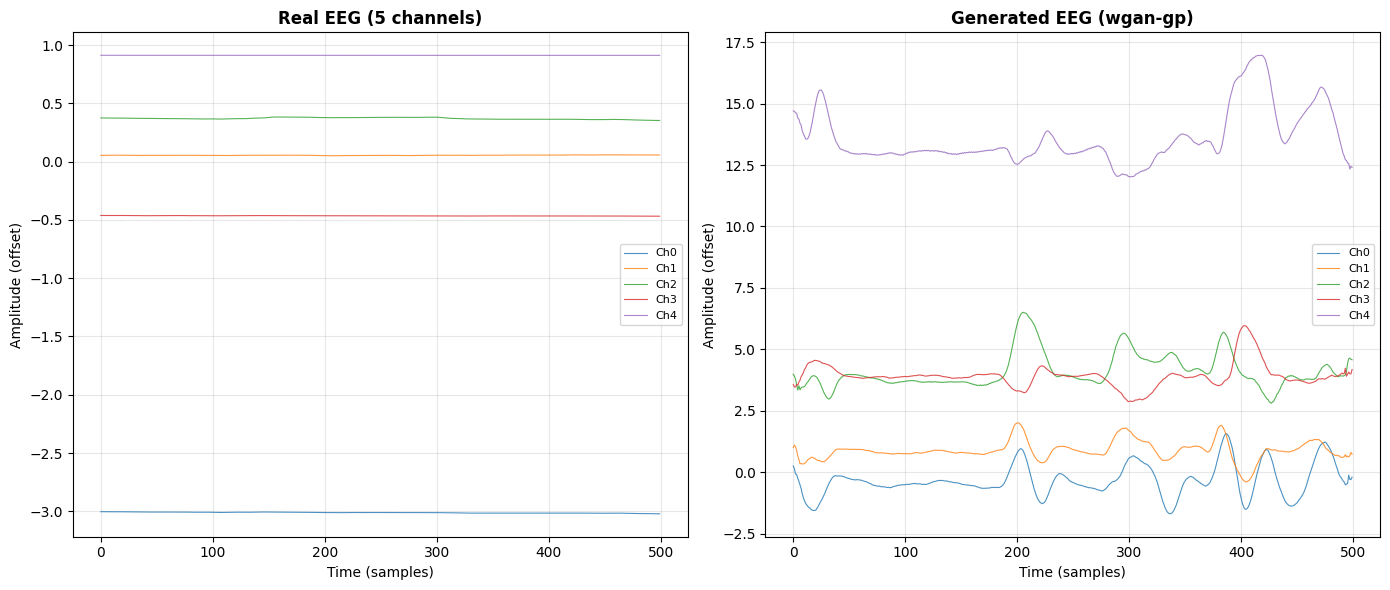

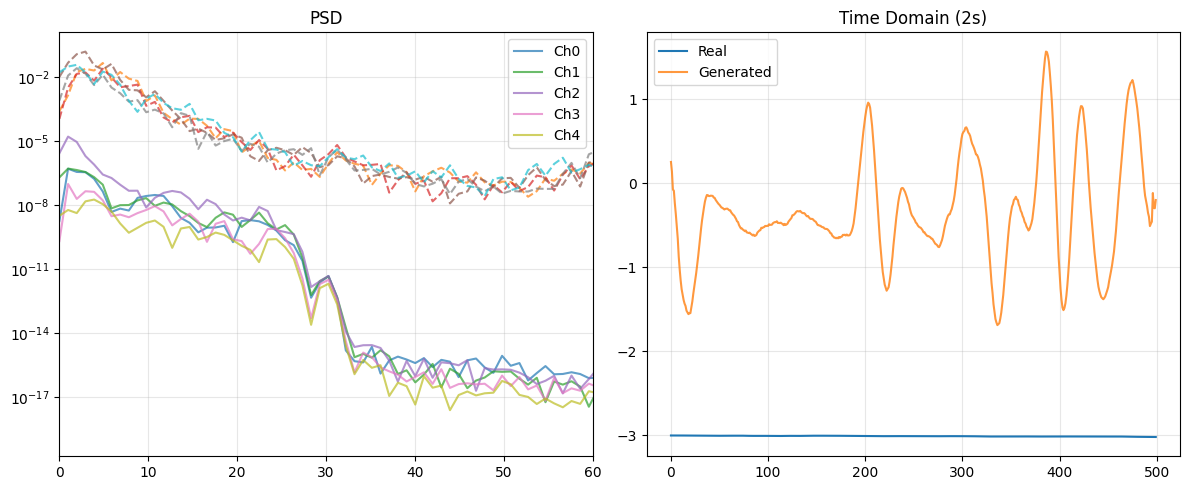

✓ Saved results for eyes_open

✓ Generated data shape: (100, 16, 500)
   Matches real data: False


In [4]:
# Train with WGAN-GP (now with PSD loss - smooth signals!)
print(f"\n{'='*60}")
print(f"Training on {segments_open.shape[1]} channels × {segments_open.shape[2]} timepoints")
print(f"{'='*60}\n")

trainer_open = EEGGANTrainer(segments_open, name='eyes_open', device=device, gan_type='wgan-gp')
trainer_open.train(epochs=100)
synthetic_open = trainer_open.generate(100)

eval_open = trainer_open.evaluate(synthetic_open)
print(f"\n{'='*60}\nRESULTS: {eval_open['overall_score']:.1f}/100 - {eval_open['quality']}\n{'='*60}")

# Visualizations
trainer_open.plot_comparison(synthetic_open, save_path='../../figures/eyes_open_gan.png')
trainer_open.plot_psd_comparison(synthetic_open, save_path='../../figures/eyes_open_psd.png')
trainer_open.save_results(synthetic_open, eval_open)

print(f"\n✓ Generated data shape: {synthetic_open.shape}")
print(f"   Matches real data: {synthetic_open.shape == segments_open.shape[1:]}")

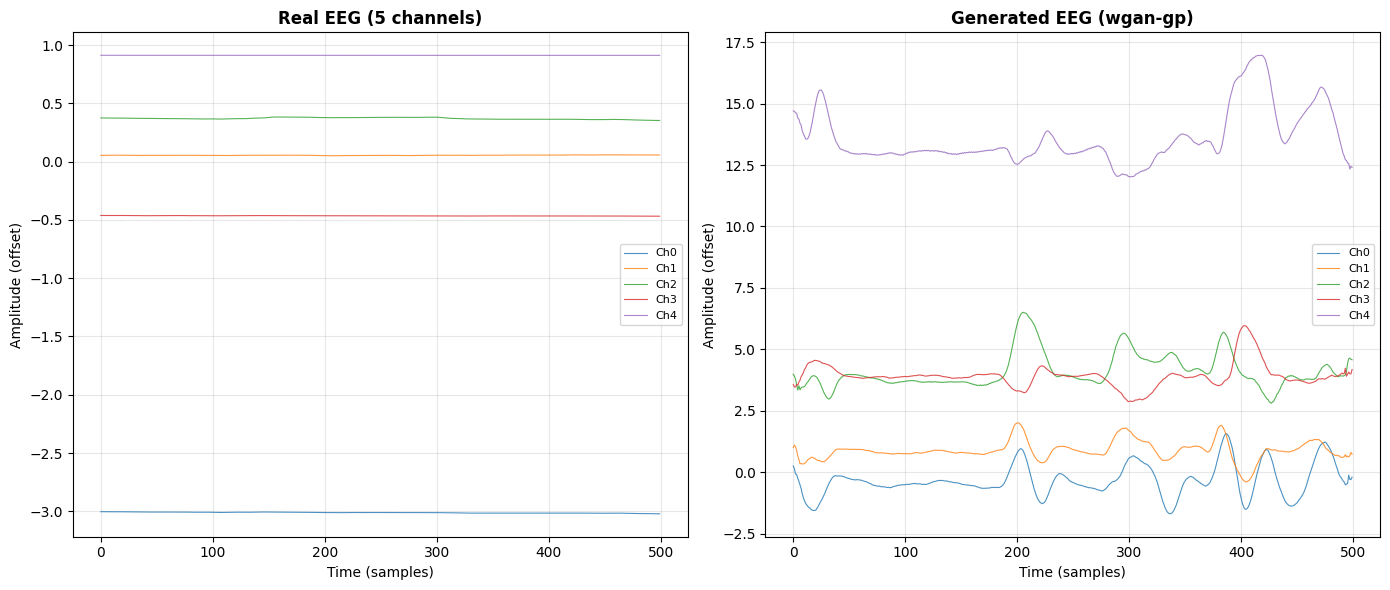

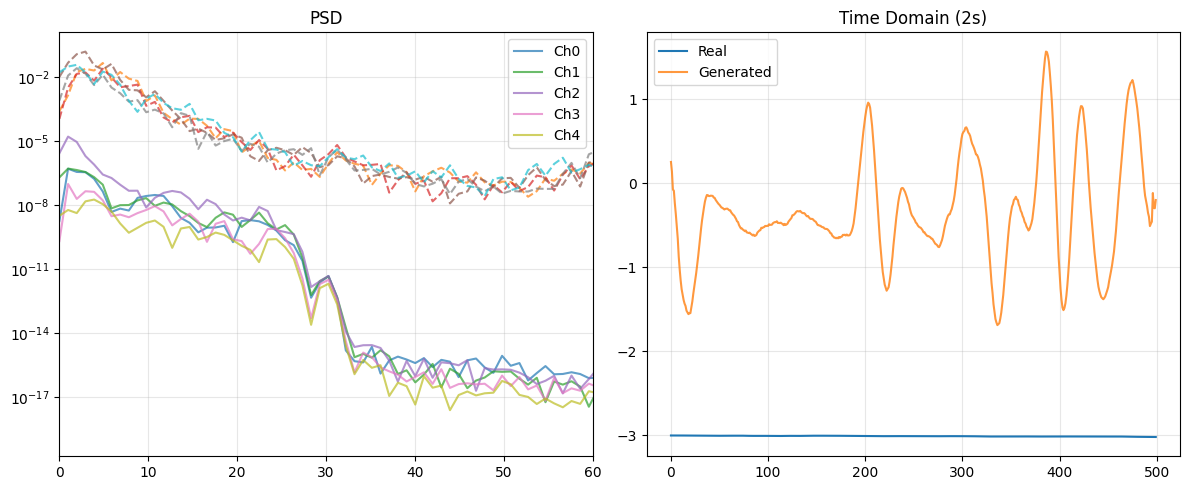

In [12]:
trainer_open.plot_comparison(synthetic_open)
trainer_open.plot_psd_comparison(synthetic_open)

In [5]:
# Train with WGAN-GP (now with PSD loss - smooth signals!)
print(f"\n{'='*60}")
print(f"Training on {segments_closed.shape[1]} channels × {segments_closed.shape[2]} timepoints")
print(f"{'='*60}\n")

trainer_closed = EEGGANTrainer(segments_closed, name='eyes_closed', device=device, gan_type='wgan-gp')
trainer_closed.train(epochs=100)
synthetic_closed = trainer_closed.generate(100)

eval_closed = trainer_closed.evaluate(synthetic_closed)
print(f"\n{'='*60}\nRESULTS: {eval_closed['overall_score']:.1f}/100 - {eval_closed['quality']}\n{'='*60}")

# Visualizations
trainer_closed.plot_comparison(synthetic_closed, save_path='../../figures/eyes_closed_gan.png')
trainer_closed.plot_psd_comparison(synthetic_closed, save_path='../../figures/eyes_closed_psd.png')
trainer_closed.save_results(synthetic_closed, eval_closed)

print(f"\n✓ Generated data shape: {synthetic_closed.shape}")
print(f"   Matches real data: {synthetic_closed.shape == segments_closed.shape[1:]}")


Training on 16 channels × 500 timepoints

✓ Initialized WGAN-GP GAN: eyes_closed
  Data: (443, 16, 500), Device: cuda
  ⚠️ Small dataset - using regularization
  G: 4,267,952 params (FREQUENCY-AWARE)
  D: 294,593 params

=== Training WGAN-GP (STAGED) ===
Stage 1 (ep 1-30): Focus on PSD
Stage 2 (ep 31+): Balance PSD + Wasserstein
Ep 10/100 [PSD] | G 7678.278 | D -20.864 | M 0.0222 | ✓
Ep 10/100 [PSD] | G 7678.278 | D -20.864 | M 0.0222 | ✓
Ep 20/100 [PSD] | G 5752.243 | D -27.134 | M 0.0039 | ✓
Ep 20/100 [PSD] | G 5752.243 | D -27.134 | M 0.0039 | ✓



Training on 16 channels × 500 timepoints

✓ Initialized WGAN-GP GAN: eyes_closed
  Data: (443, 16, 500), Device: cuda
  ⚠️ Small dataset - using regularization
  G: 4,267,952 params (FREQUENCY-AWARE)
  D: 294,593 params

=== Training WGAN-GP (STAGED) ===
Stage 1 (ep 1-30): Focus on PSD
Stage 2 (ep 31+): Balance PSD + Wasserstein
Ep 10/100 [PSD] | G 7678.278 | D -20.864 | M 0.0222 | ✓
Ep 10/100 [PSD] | G 7678.278 | D -20.864 | M 0.0222 | ✓
Ep 20/100 [PSD] | G 5752.243 | D -27.134 | M 0.0039 | ✓
Ep 20/100 [PSD] | G 5752.243 | D -27.134 | M 0.0039 | ✓


KeyboardInterrupt: 

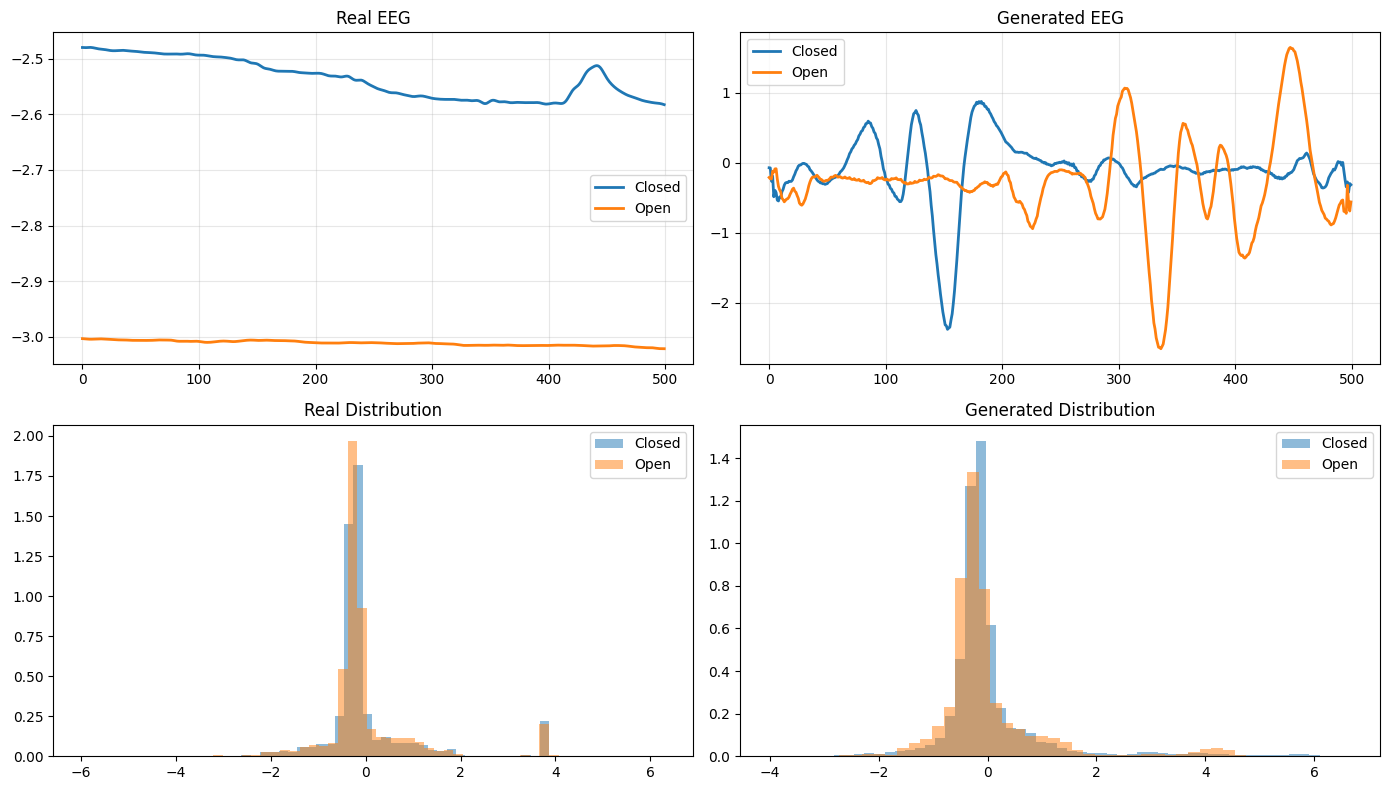


FINAL SUMMARY
Eyes Closed: 53.4/100 - Fair ⭐⭐⭐
Eyes Open:   44.1/100 - Fair ⭐⭐⭐
Average:     48.8/100


In [ ]:
# Final comparison - FIXED to show single channel clearly
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot SINGLE channel (channel 0) for time domain clarity
axes[0, 0].plot(segments_closed[0, 0], 'b-', lw=1.5, alpha=0.8, label='Closed')
axes[0, 0].plot(segments_open[0, 0], 'r-', lw=1.5, alpha=0.8, label='Open')
axes[0, 0].set_title('Real EEG (Channel 0)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time (samples)')
axes[0, 0].set_ylabel('Amplitude (normalized)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(synthetic_closed[0, 0], 'b-', lw=1.5, alpha=0.8, label='Closed')
axes[0, 1].plot(synthetic_open[0, 0], 'r-', lw=1.5, alpha=0.8, label='Open')
axes[0, 1].set_title('Generated EEG (Channel 0)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Time (samples)')
axes[0, 1].set_ylabel('Amplitude (normalized)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Histograms
axes[1, 0].hist(segments_closed.flatten(), bins=50, alpha=0.5, label='Closed', density=True, color='b')
axes[1, 0].hist(segments_open.flatten(), bins=50, alpha=0.5, label='Open', density=True, color='r')
axes[1, 0].set_title('Real Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Amplitude')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()

axes[1, 1].hist(synthetic_closed.flatten(), bins=50, alpha=0.5, label='Closed', density=True, color='b')
axes[1, 1].hist(synthetic_open.flatten(), bins=50, alpha=0.5, label='Open', density=True, color='r')
axes[1, 1].set_title('Generated Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Amplitude')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../../figures/final_comparison.png', dpi=150)
plt.show()

print(f"\n{'='*70}\nFINAL SUMMARY\n{'='*70}")
print(f"Eyes Closed: {eval_closed['overall_score']:.1f}/100 - {eval_closed['quality']}")
print(f"Eyes Open:   {eval_open['overall_score']:.1f}/100 - {eval_open['quality']}")
print(f"Average:     {(eval_closed['overall_score'] + eval_open['overall_score'])/2:.1f}/100")
print(f"{'='*70}")